In [ ]:
!pip install git+https://github.com/deepmind/dm-haiku > /dev/null 2>&1
!pip install git+git://github.com/deepmind/rlax.git > /dev/null 2>&1

In [ ]:
import jax
from jax import jit, grad, vmap
import jax.numpy as jnp
from jax.experimental import optix
import haiku as hk
import rlax

import gym
from functools import partial
import numpy as np

import random
from IPython.display import clear_output
from collections import deque
from typing import Callable, Mapping, NamedTuple, Tuple, Sequence

import matplotlib.pyplot as plt
%matplotlib inline
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Hyperparameters

In [ ]:
NUM_EPISODES = 5000
BATCH_SIZE   = 32
GAMMA        = 0.99
LEARNING_RATE = 1e-3
SEED = 1729 

# Replay Buffer

In [ ]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = jnp.expand_dims(state, 0)
        next_state = jnp.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (jnp.concatenate(state), jnp.concatenate(next_state), 
                jnp.asarray(action), jnp.asarray(reward), 
                (1.-jnp.asarray(done, dtype=jnp.float32))*GAMMA)
    
    def __len__(self):
        return len(self.buffer)

# $\epsilon$-Greedy schedule


In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * jnp.exp(-1. * frame_idx / epsilon_decay)

# Plotting

In [ ]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

# Training 

In [ ]:
def build_network(num_actions: int) -> hk.Transformed:

  def q(obs):
    network = hk.Sequential(
        [hk.Linear(128), jax.nn.relu, hk.Linear(128), jax.nn.relu,
         hk.Linear(num_actions)])
    return network(obs)

  return hk.transform(q)

In [ ]:
def main():
  # Build env
  env_id = "CartPole-v0"
  env = gym.make(env_id)
  replay_buffer = ReplayBuffer(2000)

  #logging
  losses = []
  all_rewards = []
  episode_reward = 0

  # Build and initialize DQN
  num_actions = env.action_space.n
  network = build_network(num_actions)
  sample_input = env.reset()
  rng = hk.PRNGSequence(jax.random.PRNGKey(SEED))
  net_params = network.init(next(rng), sample_input)
  target_params = net_params

   # Build and initialize optimizer.
  optimizer = optix.adam(LEARNING_RATE)
  opt_state = optimizer.init(net_params) 

  @jax.jit
  def policy(net_params, key, obs, epsilon):
    """Sample action from epsilon-greedy policy."""
    q = network.apply(net_params, obs)
    a = rlax.epsilon_greedy(epsilon).sample(key, q)
    return a

  @jax.jit
  def eval_policy(net_params, key, obs):
    """Sample action from greedy policy."""
    q = network.apply(net_params, obs)
    return rlax.greedy().sample(key, q)

  batched_loss = vmap(rlax.double_q_learning)
  @jax.jit
  def update(net_params, target_params, opt_state, batch):
    """Update network weights wrt Q-learning loss."""

    def dqn_learning_loss(net_params, target_params, batch):
      obs_tm1, obs_t, a_tm1, r_t, discount_t  = batch
      q_tm1 = network.apply(net_params, obs_tm1)
      q_t_value = network.apply(target_params, obs_t)
      q_t_selector = network.apply(net_params, obs_t)

      td_error = batched_loss(q_tm1, a_tm1, r_t, discount_t, q_t_value, 
                              q_t_selector)
      return jnp.mean(rlax.l2_loss(td_error))

    loss, dloss_dtheta = jax.value_and_grad(dqn_learning_loss)(net_params, 
                                                         target_params, batch)
    updates, opt_state = optimizer.update(dloss_dtheta, opt_state)
    net_params = optix.apply_updates(net_params, updates)
    return net_params, opt_state, loss

  state = env.reset()
  print(f"Training agent for {NUM_EPISODES} episodes...")
  for idx in range(1, NUM_EPISODES+1):
    epsilon = epsilon_by_frame(idx)

    #Act in the environment and update replay_buffer
    action = policy(net_params, next(rng), state, epsilon)  
    next_state, reward, done, _ = env.step(int(action))
    replay_buffer.push(state, action, reward, next_state, done)
    
  
    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > BATCH_SIZE:
      batch = replay_buffer.sample(BATCH_SIZE)
      net_params, opt_state, loss = update(net_params, target_params, 
                                           opt_state, batch)
      losses.append(float(loss))
        
    if idx % 200 == 0:
     plot(idx, all_rewards, losses)
      
    #Update Target model parameters
    if idx % 100 == 0:
      target_params = net_params

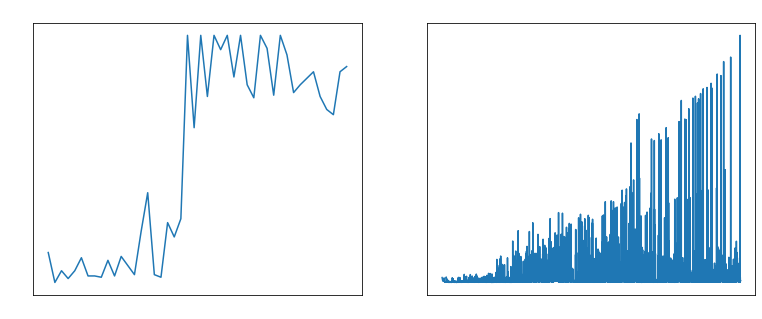

In [9]:
main()